In [ ]:
# import sys
# import os
# os.environ["PYSPARK_PYTHON"] = sys.executable
# os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [1]:
from pyspark.sql.functions import col, concat_ws
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, NGram, HashingTF, IDF
from pyspark.sql.functions import col
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import split, trim, size
from pyspark.sql.functions import length
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import StringIndexer
from textblob import TextBlob
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from collections import Counter
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import explode, lit, rand
import pyspark.sql.functions as F
from wordcloud import WordCloud,STOPWORDS
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re
import string
import pandas as pd
from pyspark.sql.types import FloatType

In [2]:
reviews = pd.read_csv('Musical_instruments_reviews.csv')

In [3]:
MIN_TOKEN_LENGTH = 2
SPARK_MEMORY = "8g"

spark = SparkSession.builder \
    .appName("Amazon Sentiment Analysis") .config("spark.driver.memory", SPARK_MEMORY) \
    .getOrCreate()

# df3 = spark.read.csv("Musical_instruments_reviews.csv", header=True)

In [4]:
df = spark.createDataFrame(reviews)

In [ ]:
# # Sample 10% of the DataFrame without replacement
# sampled_df = df.sample(withReplacement=False, fraction=0.1)

# # Write the sampled DataFrame to a JSON file
# sampled_df.write.mode("overwrite").json("sampled_reviews.json")

In [ ]:
# # Drop the 'overall' column
# df1 = df.drop("overall")

# # Take 10% of the data
# fraction = 0.1
# df_sampled = df1.sample(withReplacement=False, fraction=fraction, seed=42)

# # Save the sampled data to a JSON file
# df_sampled.write.mode("overwrite").json("sampled_reviews.json")

In [5]:
#
df.show(5)

+--------------+----------+--------------------+--------+--------------------+-------+--------------------+--------------+-----------+
|    reviewerID|      asin|        reviewerName| helpful|          reviewText|overall|             summary|unixReviewTime| reviewTime|
+--------------+----------+--------------------+--------+--------------------+-------+--------------------+--------------+-----------+
|A2IBPI20UZIR0U|1384719342|cassandra tu "Yea...|  [0, 0]|Not much to write...|    5.0|                good|    1393545600|02 28, 2014|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|The product does ...|    5.0|                Jake|    1363392000|03 16, 2013|
|A195EZSQDW3E21|1384719342|Rick Bennette "Ri...|  [1, 1]|The primary job o...|    5.0|It Does The Job Well|    1377648000|08 28, 2013|
|A2C00NNG1ZQQG2|1384719342|RustyBill "Sunday...|  [0, 0]|Nice windscreen p...|    5.0|GOOD WINDSCREEN F...|    1392336000|02 14, 2014|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0

In [6]:
df = df.fillna({'reviewText': 'Missing'})

In [7]:
# Combine 'reviewText' and 'summary' into a new column 'reviews'
df = df.withColumn('reviews', concat_ws('', col('reviewText'), col('summary')))

# Drop the original 'reviewText' and 'summary' columns
df = df.drop('reviewText', 'summary')

In [8]:
df.show()

+--------------+----------+--------------------+--------+-------+--------------+-----------+--------------------+
|    reviewerID|      asin|        reviewerName| helpful|overall|unixReviewTime| reviewTime|             reviews|
+--------------+----------+--------------------+--------+-------+--------------+-----------+--------------------+
|A2IBPI20UZIR0U|1384719342|cassandra tu "Yea...|  [0, 0]|    5.0|    1393545600|02 28, 2014|Not much to write...|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|    5.0|    1363392000|03 16, 2013|The product does ...|
|A195EZSQDW3E21|1384719342|Rick Bennette "Ri...|  [1, 1]|    5.0|    1377648000|08 28, 2013|The primary job o...|
|A2C00NNG1ZQQG2|1384719342|RustyBill "Sunday...|  [0, 0]|    5.0|    1392336000|02 14, 2014|Nice windscreen p...|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0]|    5.0|    1392940800|02 21, 2014|This pop filter i...|
|A2A039TZMZHH9Y|B00004Y2UT| Bill Lewey "blewey"|  [0, 0]|    5.0|    1356048000|12 21, 2

In [9]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, IntegerType

# Cast the column to IntegerType
df = df.withColumn("overall", col("overall").cast(IntegerType()))

# Define the sentiment function
def sent(overall):
    if overall is None:
        return 'Unknown'
    elif overall == 3:
        return 'Neutral'
    elif overall > 3:
        return 'Positive'
    else:
        return 'Negative'

# Register the UDF
sent_udf = udf(sent, StringType())

# Apply the UDF
df = df.withColumn("Sentiment", sent_udf(col("overall")))




In [10]:
df.show(10)

+--------------+----------+--------------------+--------+-------+--------------+-----------+--------------------+---------+
|    reviewerID|      asin|        reviewerName| helpful|overall|unixReviewTime| reviewTime|             reviews|Sentiment|
+--------------+----------+--------------------+--------+-------+--------------+-----------+--------------------+---------+
|A2IBPI20UZIR0U|1384719342|cassandra tu "Yea...|  [0, 0]|      5|    1393545600|02 28, 2014|Not much to write...| Positive|
|A14VAT5EAX3D9S|1384719342|                Jake|[13, 14]|      5|    1363392000|03 16, 2013|The product does ...| Positive|
|A195EZSQDW3E21|1384719342|Rick Bennette "Ri...|  [1, 1]|      5|    1377648000|08 28, 2013|The primary job o...| Positive|
|A2C00NNG1ZQQG2|1384719342|RustyBill "Sunday...|  [0, 0]|      5|    1392336000|02 14, 2014|Nice windscreen p...| Positive|
| A94QU4C90B1AX|1384719342|       SEAN MASLANKA|  [0, 0]|      5|    1392940800|02 21, 2014|This pop filter i...| Positive|
|A2A039T

In [ ]:
# # Sample 10% of the DataFrame without replacement
# sampled_df = df.sample(withReplacement=False, fraction=0.1)

# # Write the sampled DataFrame to a JSON file
# sampled_df.write.mode("overwrite").json("sampled_reviews.json")

In [ ]:
# sentiment_counts = sampled_df.groupBy("sentiment").count()
# sentiment_counts.show()

+---------+-----+
|sentiment|count|
+---------+-----+
| Positive|  948|
|  Neutral|   79|
| Negative|   33|
+---------+-----+



In [ ]:
# sampled_df = sampled_df.drop('sentiement')
# sampled_df.write.mode("overwrite").json("sampled_reviews_without_target.json")

In [ ]:


# # Split 'reviewTime' into 'date' and 'year'
# df = df.withColumn('date', split(df['reviewTime'], ',').getItem(0))
# df = df.withColumn('year', trim(split(df['reviewTime'], ',').getItem(1)))

# # Split 'date' into 'month' and 'day'
# df = df.withColumn('month', split(df['date'], ' ').getItem(0))
# df = df.withColumn('day', split(df['date'], ' ').getItem(1))

# # Drop 'reviewTime' and 'date' columns
# df = df.drop('reviewTime', 'date')

# # Show the result
# df.show(5)


In [11]:
df = df.drop('reviewerName', 'unixReviewTime')

In [12]:
def clean_review(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
clean_review_udf = udf(clean_review, StringType())

In [14]:
df = df.withColumn('reviews', clean_review_udf(df['reviews']))

In [15]:
df.show(5)


+--------------+----------+--------+-------+-----------+--------------------+---------+
|    reviewerID|      asin| helpful|overall| reviewTime|             reviews|Sentiment|
+--------------+----------+--------+-------+-----------+--------------------+---------+
|A2IBPI20UZIR0U|1384719342|  [0, 0]|      5|02 28, 2014|not much to write...| Positive|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|03 16, 2013|the product does ...| Positive|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|08 28, 2013|the primary job o...| Positive|
|A2C00NNG1ZQQG2|1384719342|  [0, 0]|      5|02 14, 2014|nice windscreen p...| Positive|
| A94QU4C90B1AX|1384719342|  [0, 0]|      5|02 21, 2014|this pop filter i...| Positive|
+--------------+----------+--------+-------+-----------+--------------------+---------+
only showing top 5 rows



In [16]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each',
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above',
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't",
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from',
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs',
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

def remove_stopwords(text):
    if text is None:
        return ""
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

remove_stopwords_udf = udf(remove_stopwords, StringType())


In [17]:
df = df.withColumn('reviews', remove_stopwords_udf(df['reviews']))

In [ ]:
# def get_polarity(text):
#     try:
#         return float(TextBlob(str(text)).sentiment.polarity)
#     except:
#         return 0.0

# polarity_udf = udf(get_polarity, FloatType())
# df = df.withColumn('polarity', polarity_udf(df['reviews']))

In [ ]:
# df = df.withColumn('review_len', length(df['reviews']))
# df = df.withColumn('word_count', size(split(df['reviews'], ' ')))

# df.select('reviews', 'polarity', 'review_len', 'word_count').show(5)

In [18]:
positive_review = df.filter(df["Sentiment"] == 'Positive').na.drop()
neutral_review  = df.filter(df["Sentiment"] == 'Neutral').na.drop()
negative_review = df.filter(df["Sentiment"] == 'Negative').na.drop()

In [19]:
negative_review.show(10)

+--------------+----------+-------+-------+-----------+--------------------+---------+
|    reviewerID|      asin|helpful|overall| reviewTime|             reviews|Sentiment|
+--------------+----------+-------+-------+-----------+--------------------+---------+
|A2PD27UKAD3Q00|B00005ML71| [0, 0]|      2|08 17, 2013|bought use keyboa...| Negative|
|A12ABV9NU02O29|B000068NW5| [2, 2]|      2| 07 6, 2011|didnt expect cabl...| Negative|
|A1L7M2JXN4EZCR|B000068NW5| [0, 0]|      1| 02 9, 2014|hums crackles thi...| Negative|
|A3UD50M7M72150|B000068NW5| [0, 0]|      1|03 14, 2014|im procheapo hate...| Negative|
|A1W3CEEQBJ4GTN|B000068NZC| [0, 0]|      2|09 16, 2013|bought canon vixi...| Negative|
| AEN6KDJ3AJDK6|B000068O4H| [0, 2]|      2|12 30, 2013|got plug xlr cabl...| Negative|
|A3AOB0VF6H0IF4|B000165DSM| [0, 0]|      1|01 27, 2013|received time sta...| Negative|
|A27DR1VO079F1V|B000165DSM| [0, 0]|      1|02 19, 2014|things terrible o...| Negative|
| AAGD3GA9ZVPLQ|B0002CZSJO| [0, 0]|      2|

In [20]:
df.printSchema()


root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- Sentiment: string (nullable = true)



In [21]:
df.select("Sentiment").limit(5).show()


+---------+
|Sentiment|
+---------+
| Positive|
| Positive|
| Positive|
| Positive|
| Positive|
+---------+



In [22]:
df.show(5)

+--------------+----------+--------+-------+-----------+--------------------+---------+
|    reviewerID|      asin| helpful|overall| reviewTime|             reviews|Sentiment|
+--------------+----------+--------+-------+-----------+--------------------+---------+
|A2IBPI20UZIR0U|1384719342|  [0, 0]|      5|02 28, 2014|not much write bu...| Positive|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|03 16, 2013|product exactly q...| Positive|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|08 28, 2013|primary job devic...| Positive|
|A2C00NNG1ZQQG2|1384719342|  [0, 0]|      5|02 14, 2014|nice windscreen p...| Positive|
| A94QU4C90B1AX|1384719342|  [0, 0]|      5|02 21, 2014|pop filter great ...| Positive|
+--------------+----------+--------+-------+-----------+--------------------+---------+
only showing top 5 rows



In [ ]:
# df.cache()


In [ ]:
# pdf = df.select("*").toPandas()
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# pdf['Sentiment'] = le.fit_transform(pdf['Sentiment'])
# df = spark.createDataFrame(pdf)

In [23]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sentiment", outputCol="Sentiment_Indexed")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)
df.select("Sentiment", "Sentiment_Indexed").distinct().show()

+---------+-----------------+
|Sentiment|Sentiment_Indexed|
+---------+-----------------+
| Positive|              0.0|
| Negative|              2.0|
|  Neutral|              1.0|
+---------+-----------------+



In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.ml.feature import StringIndexer

# spark = SparkSession.builder.getOrCreate()
# data = [("Positive",), ("Negative",), ("Neutral",)]
# df2 = spark.createDataFrame(data, ["Sentiment"])
# indexer = StringIndexer(inputCol="Sentiment", outputCol="Sentiment_Indexed")
# model = indexer.fit(df2)
# df2 = model.transform(df2)
# df2.show()

In [24]:
df.groupBy('Sentiment').count().orderBy('count', ascending=False).show()

+---------+-----+
|Sentiment|count|
+---------+-----+
| Positive| 9022|
|  Neutral|  772|
| Negative|  467|
+---------+-----+



In [ ]:
# # Extracting 'reviews' for processing
# df_features = df.select("reviews").alias("review_features")
# df_features.show(5)

In [ ]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import col, udf
# from pyspark.sql.types import ArrayType, StringType
# from pyspark.ml.feature import Tokenizer, HashingTF, IDF
# import nltk
# from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')

In [25]:
# 1. Tokenization
tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
df_tokenized = tokenizer.transform(df)
df_tokenized.show()

+--------------+----------+--------+-------+-----------+--------------------+---------+-----------------+--------------------+
|    reviewerID|      asin| helpful|overall| reviewTime|             reviews|Sentiment|Sentiment_Indexed|               words|
+--------------+----------+--------+-------+-----------+--------------------+---------+-----------------+--------------------+
|A2IBPI20UZIR0U|1384719342|  [0, 0]|      5|02 28, 2014|not much write bu...| Positive|              0.0|[not, much, write...|
|A14VAT5EAX3D9S|1384719342|[13, 14]|      5|03 16, 2013|product exactly q...| Positive|              0.0|[product, exactly...|
|A195EZSQDW3E21|1384719342|  [1, 1]|      5|08 28, 2013|primary job devic...| Positive|              0.0|[primary, job, de...|
|A2C00NNG1ZQQG2|1384719342|  [0, 0]|      5|02 14, 2014|nice windscreen p...| Positive|              0.0|[nice, windscreen...|
| A94QU4C90B1AX|1384719342|  [0, 0]|      5|02 21, 2014|pop filter great ...| Positive|              0.0|[pop, 

In [26]:
df_tokenized.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- Sentiment_Indexed: double (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
# # cHECKING FOR MISSPELLED WORDS
# # Configuration

# DOMAIN_WORDS = [
#     "epiphone", "fender", "windscreen", "yamaha", "ive", "monster",
#     "plugin", "bluetooth", "mic", "ipad", "ipod", "amps", "distortion",
#     "gig", "amp", "aux", "acoustic", "pedal", "tuner", "preamp",
#     "podcast", "adapter", "playlist"
# ]
# # Initialize spell checker
# def init_spell_checker():
#     checker = SpellChecker()
#     checker.word_frequency.load_words(DOMAIN_WORDS)
#     return checker

# # Spell-check function
# @pandas_udf(ArrayType(StringType()))
# def check_misspellings(tokens: pd.Series) -> pd.Series:
#     checker = init_spell_checker()
#     def check_tokens(token_list):
#         # Handle None or non-list inputs
#         if token_list is None or not isinstance(token_list, (list, tuple)):
#             return []
#         # Handle empty lists
#         if len(token_list) == 0:
#             return []
#         # Process valid tokens
#         valid_tokens = [t.lower() for t in token_list if isinstance(t, str) and len(t) >= MIN_TOKEN_LENGTH and not t.isdigit()]
#         return list(checker.unknown(valid_tokens))
#     return tokens.apply(check_tokens)

# # Main processing
# def main(df_tokenized):
#     # Cache and repartition
#     df_tokenized.cache()
#     df_tokenized = df_tokenized.repartition(8)  # Adjust based on cores

#     # Add misspelled words column
#     result_df = df_tokenized.withColumn("misspelled_words", check_misspellings("words"))

#     # Show sample results
#     print("Sample rows with misspellings:")
#     result_df.select("reviewerID", "reviews", "words", "misspelled_words").show(5, truncate=False)

#     # Count total misspelled words
#     misspelling_count = result_df.select(explode("misspelled_words").alias("misspelled_word")).count()
#     print(f"Total number of misspelled words: {misspelling_count}")

#     # Cleanup
#     df_tokenized.unpersist()


# # Run spell-checking (assuming df_tokenized is loaded)
# main(df_tokenized)

# # Optional: Stop SparkSession
# # spark.stop()

In [27]:
! pip install spacy

In [28]:
# 2. Lemmatization UDF
import spacy
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import ArrayType, StringType

nlp = spacy.load('en_core_web_sm')

def lemmatize(tokens):
    # Handle None, non-list, or empty inputs
    if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
        return []
    # Join tokens into a string for SpaCy processing
    text = " ".join([t for t in tokens if isinstance(t, str)])
    # Process the text with SpaCy NLP pipeline
    doc = nlp(text)
    # Return all lemmas, without filtering stopwords or punctuation
    return [token.lemma_ for token in doc if not token.is_punct]

# Register the UDF with PySpark
lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# Apply the UDF to create the 'lemmatized' column
df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(df_tokenized["words"]))

# # Add word counts for validation
# df_tokenized = df_tokenized.withColumn("words_count", size(col("words"))) \
#                            .withColumn("lemmatized_count", size(col("lemmatized")))

# Show the results
print("Sample rows with lemmatization:")
df_tokenized.select("reviews", "words", "lemmatized").show(10, truncate=False)

# Validation checks
total_rows = df_tokenized.count()
non_null_lemmatized = df_tokenized.filter(col("lemmatized").isNotNull()).count()
non_empty_lemmatized = df_tokenized.filter(size(col("lemmatized")) > 0).count()

print(f"Total rows: {total_rows}")
print(f"Rows with non-null lemmatized column: {non_null_lemmatized}")
print(f"Rows with non-empty lemmatized lists: {non_empty_lemmatized}")

print("Rows with empty lemmatized lists (if any):")
df_tokenized.filter(size(col("lemmatized")) == 0) \
            .select("reviewerID", "reviews", "words", "lemmatized") \
            .show(5, truncate=False)

Sample rows with lemmatization:
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# 3. Balancing
major_class_count = df_tokenized.filter(F.col("Sentiment_Indexed") == 0.0).count()
df_class0 = df_tokenized.filter(F.col("Sentiment_Indexed") == 0.0)
df_class1 = df_tokenized.filter(F.col("Sentiment_Indexed") == 1.0)
df_class2 = df_tokenized.filter(F.col("Sentiment_Indexed") == 2.0)

fraction1 = float(major_class_count) / df_class1.count()
fraction2 = float(major_class_count) / df_class2.count()

df_class1_oversampled = df_class1.sample(withReplacement=True, fraction=fraction1, seed=42)
df_class2_oversampled = df_class2.sample(withReplacement=True, fraction=fraction2, seed=42)

df_balanced = df_class0.union(df_class1_oversampled).union(df_class2_oversampled)
df_balanced = df_balanced.orderBy(F.rand(seed=42))

# Verify balancing
df_balanced.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 9022|
|              1.0| 9080|
|              2.0| 9067|
+-----------------+-----+



In [30]:
# 3. TF-IDF Vectorization
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import col


# Step 1: Generate bigrams (ngram_range=(2,2))
ngram = NGram(n=2, inputCol="lemmatized", outputCol="bigrams")
df_ngram = ngram.transform(df_balanced)

# Step 2: Apply HashingTF to create term frequency vectors (max_features=5000)
hashing_tf = HashingTF(inputCol="bigrams", outputCol="raw_features", numFeatures=5000)
df_tf = hashing_tf.transform(df_ngram)

# Configure IDF
# idf = IDF(inputCol="raw_features", outputCol="tfidf")
# # Apply HashingTF to create term frequency vectors
# df_tokenized = hashing_tf.transform(df_tokenized)
# Fit and save the model
# idf_model = idf.fit(df_tokenized)
# SAVE the IDFModel
# Step 3: Apply IDF to compute TF-IDF scores
idf = IDF(inputCol="raw_features", outputCol="tfidf")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)
# idf_model.save("/content/idf_model2")
idf_model.save("/content/idf_model4")
print("IDF model saved to /content/idf_model3")
# Transform the data
# df_tokenized = idf_model.transform(df_tokenized)

# # Apply HashingTF to create term frequency vectors
# df_tokenized = hashing_tf.transform(df_tokenized)

# # Apply IDF to compute TF-IDF scores
# df_tokenized = idf.fit(df_tokenized).transform(df_tokenized)

# Step 5: Show sample results
print("Sample rows with TF-IDF:")
df_tfidf.select("reviews", "lemmatized", "bigrams", "tfidf").show(10, truncate=False)

IDF model saved to /content/idf_model3
Sample rows with TF-IDF:
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [31]:
columns_to_drop = [
    "asin",
    "reviewerID",
    "reviews",
    "Sentiment",
    "overall",
    "words",
    "lemmatized",
    "words_count",
    "lemmatized_count",
    "helpful",
    "year",
    "month",
    "day",
    "polarity",
    "review_len",
    "word_count",
    "bigrams",
    "raw_features",
    "reviewTime"


]

df_cleaned = df_tfidf.drop(*columns_to_drop)

In [32]:
df_cleaned.printSchema()

root
 |-- Sentiment_Indexed: double (nullable = false)
 |-- tfidf: vector (nullable = true)



In [33]:
# Group by the target column and count
df_balanced.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()


+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 9022|
|              1.0| 9080|
|              2.0| 9067|
+-----------------+-----+



In [ ]:
# from pyspark.sql import functions as F

# # Calculate the number of samples in the majority class (class 0)
# major_class_count = df_cleaned.filter(F.col("Sentiment_Indexed") == 0.0).count()

# # Get the dataframes for each class
# df_class0 = df_cleaned.filter(F.col("Sentiment_Indexed") == 0.0)
# df_class1 = df_cleaned.filter(F.col("Sentiment_Indexed") == 1.0)
# df_class2 = df_cleaned.filter(F.col("Sentiment_Indexed") == 2.0)

# # Calculate the oversampling fraction for minority classes
# fraction1 = float(major_class_count) / df_class1.count()
# fraction2 = float(major_class_count) / df_class2.count()

# # Oversample the minority classes
# df_class1_oversampled = df_class1.sample(withReplacement=True, fraction=fraction1, seed=42)
# df_class2_oversampled = df_class2.sample(withReplacement=True, fraction=fraction2, seed=42)

# # Combine the oversampled dataframes with the majority class
# df_balanced = df_class0.union(df_class1_oversampled).union(df_class2_oversampled)

# # Check the balance of the new dataframe
# df_balanced.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

# # If you need to shuffle the dataset (recommended)
# df_balanced = df_balanced.orderBy(F.rand(seed=42))

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 9022|
|              1.0| 9080|
|              2.0| 9067|
+-----------------+-----+



In [34]:

# Split the data (80% train, 10% validation, 10% test)
train_data, val_data, test_data = df_cleaned.randomSplit([0.8, 0.1, 0.1], seed=42)

# Cache the dataframes for better performance
train_data.cache()
val_data.cache()
test_data.cache()
train_data.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 7199|
|              1.0| 7236|
|              2.0| 7209|
+-----------------+-----+



In [35]:
train_data.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 7199|
|              1.0| 7236|
|              2.0| 7209|
+-----------------+-----+



In [ ]:
# # 3. Balancing
# major_class_count = train_data.filter(F.col("Sentiment_Indexed") == 0.0).count()
# df_class0 = train_data.filter(F.col("Sentiment_Indexed") == 0.0)
# df_class1 = train_data.filter(F.col("Sentiment_Indexed") == 1.0)
# df_class2 = train_data.filter(F.col("Sentiment_Indexed") == 2.0)

# fraction1 = float(major_class_count) / df_class1.count()
# fraction2 = float(major_class_count) / df_class2.count()

# df_class1_oversampled = df_class1.sample(withReplacement=True, fraction=fraction1, seed=42)
# df_class2_oversampled = df_class2.sample(withReplacement=True, fraction=fraction2, seed=42)

# df_balanced = df_class0.union(df_class1_oversampled).union(df_class2_oversampled)
# df_balanced = df_balanced.orderBy(F.rand(seed=42))

# # Verify balancing
# df_balanced.groupBy("Sentiment_Indexed").count().orderBy("Sentiment_Indexed").show()

+-----------------+-----+
|Sentiment_Indexed|count|
+-----------------+-----+
|              0.0| 7282|
|              1.0| 7317|
|              2.0| 7297|
+-----------------+-----+



In [ ]:

# # Check dataset sizes
# print("Train data count:", train_data.count())
# print("Validation data count:", val_data.count())


In [ ]:
# from pyspark.sql import functions as F
# import os
# import glob
# from google.colab import files

# # Combine the DataFrames
# combined_data = train_data.union(val_data)

# # Save to a single JSON file
# combined_data.coalesce(1).write.json("/content/combined_data1.json")
# print("JSON file written to /content/combined_data.json")

# # Rename the generated JSON file
# json_files = glob.glob("/content/combined_data.json/part-*.json")
# if json_files:
#     os.rename(json_files[0], "/content/combined_data.json")
#     print("JSON file prepared as /content/combined_data.json")
#     # Download the file
#     files.download("/content/combined_data.json")
# else:
#     print("Error: JSON file not found")

Training Logistic Regression...
Completed Logistic Regression
Training Decision Tree...
Completed Decision Tree
Training Random Forest...
Completed Random Forest
Training Naive Bayes...
Completed Naive Bayes
Training KNN (Approximate)...
Error with KNN (Approximate): [FIELD_NOT_FOUND] No such struct field `id` in `Sentiment_Indexed`, `tfidf`, `hashes`.
Completed KNN (Approximate)

Model Comparison:
                 Model  F1 Score  Precision    Recall  Accuracy  \
0  Logistic Regression  0.947425   0.950043  0.948175  0.948175   
3          Naive Bayes  0.805699   0.805544  0.806204  0.806204   
2        Random Forest  0.588787   0.616515  0.586861  0.586861   
1        Decision Tree  0.423128   0.524776  0.466058  0.466058   
4    KNN (Approximate)  0.000000   0.000000  0.000000  0.000000   

   Training Time (s)                                              Error  
0         430.891248                                                NaN  
3          16.586183                           

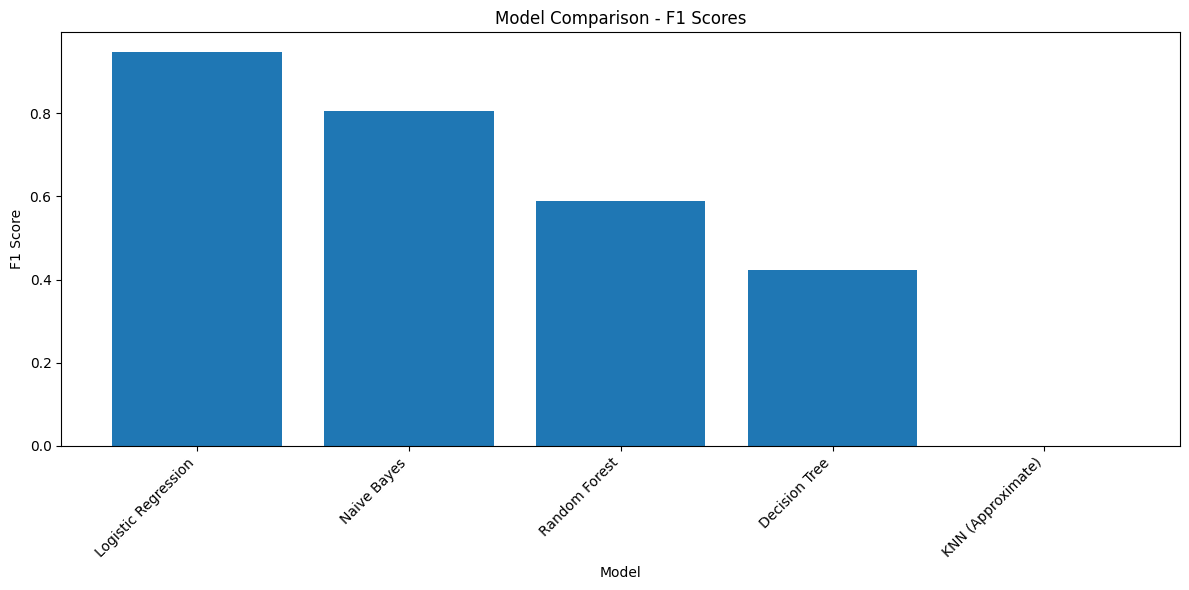

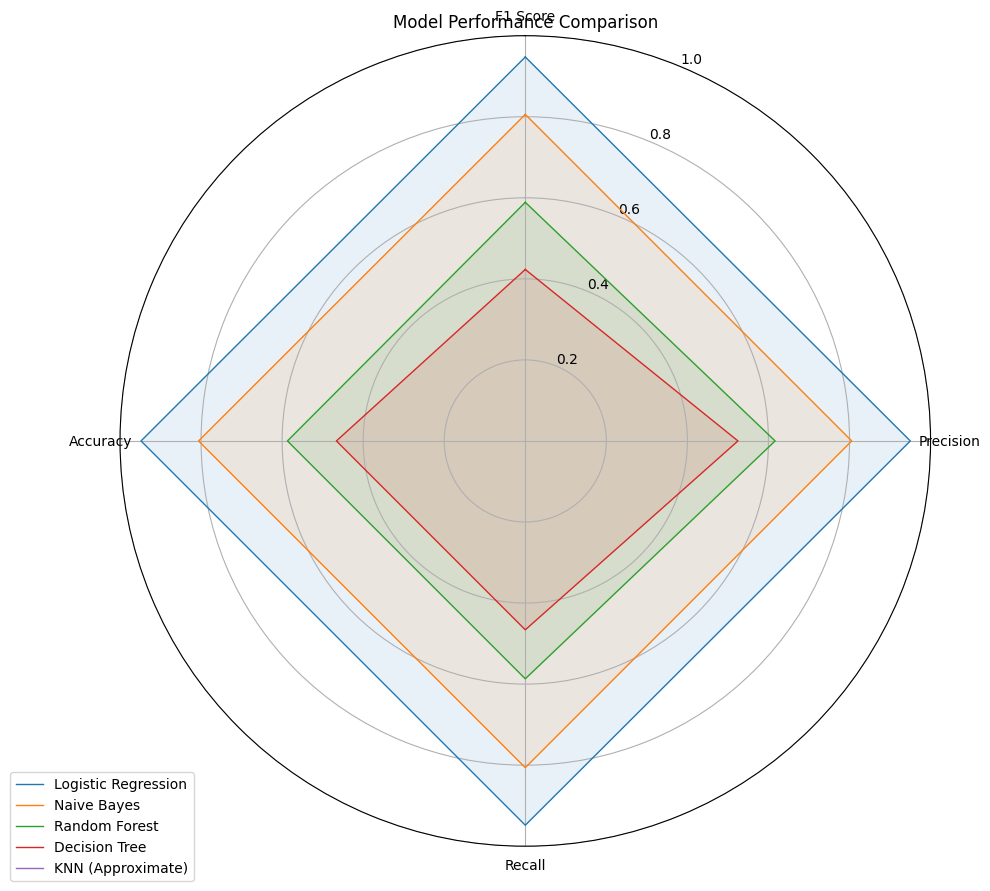

In [38]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import time
import pandas as pd
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np




# Create KNN approximation using LSH on 'tfidf' features
def knn_predict(train_data, val_data, k=5):
    """
    Approximate KNN in PySpark using Locality Sensitive Hashing on TF-IDF features
    """
    brp = BucketedRandomProjectionLSH(
        inputCol="tfidf",
        outputCol="hashes",
        numHashTables=5,
        bucketLength=2.0
    )
    brp_model = brp.fit(train_data)

    train_hashed = brp_model.transform(train_data)
    val_hashed = brp_model.transform(val_data)

    val_with_neighbors = brp_model.approxSimilarityJoin(
        val_hashed,
        train_hashed,
        threshold=100.0,
        distCol="distance"
    )

    window = Window.partitionBy("datasetA.id").orderBy("distance")
    val_with_knn = val_with_neighbors.withColumn("rank", F.row_number().over(window))
    val_with_knn = val_with_knn.filter(F.col("rank") <= k)

    val_predictions = val_with_knn.groupBy("datasetA.id") \
        .agg(
            F.first("datasetA.tfidf").alias("features"),
            F.collect_list("datasetB.Sentiment_Indexed").alias("neighbor_labels")
        )

    val_predictions = val_predictions.withColumn(
        "prediction",
        F.expr("double(array_sort(neighbor_labels)[int(size(neighbor_labels)/2)])")
    )

    return val_predictions

# Evaluation function
def get_metrics(predictions):
    metrics = {}
    for metric in ["f1", "weightedPrecision", "weightedRecall", "accuracy"]:
        evaluator = MulticlassClassificationEvaluator(
            labelCol="Sentiment_Indexed",
            predictionCol="prediction",
            metricName=metric
        )
        metrics[metric] = evaluator.evaluate(predictions)
    return metrics

# Models using 'tfidf' as features
models = {
    "Logistic Regression": LogisticRegression(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        maxIter=100,
        regParam=0.1
    ),
    "Decision Tree": DecisionTreeClassifier(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        maxDepth=5
    ),
    "Random Forest": RandomForestClassifier(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        numTrees=50,
        maxDepth=5
    ),
    "Naive Bayes": NaiveBayes(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        modelType="multinomial"
    )
    # "Linear SVC": LinearSVC(
    #     labelCol="Sentiment_Indexed",
    #     featuresCol="tfidf",
    #     maxIter=100,
    #     regParam=0.1
    # ),
    # "Gradient Boosted Trees": GBTClassifier(
    #     labelCol="Sentiment_Indexed",
    #     featuresCol="tfidf",
    #     maxIter=10,
    #     maxDepth=5
    # )
}

# Training and evaluating models
def train_evaluate(model_name, model):
    start_time = time.time()
    try:
        if model_name == "KNN (Approximate)":
            predictions = knn_predict(train_data, val_data, k=5)
        else:
            print(f"Training {model_name}...")
            model_fitted = model.fit(train_data)
            predictions = model_fitted.transform(val_data)

        metrics = get_metrics(predictions)
        training_time = time.time() - start_time

        return {
            "Model": model_name,
            "F1 Score": metrics["f1"],
            "Precision": metrics["weightedPrecision"],
            "Recall": metrics["weightedRecall"],
            "Accuracy": metrics["accuracy"],
            "Training Time (s)": training_time
        }
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        return {
            "Model": model_name,
            "F1 Score": 0,
            "Precision": 0,
            "Recall": 0,
            "Accuracy": 0,
            "Training Time (s)": 0,
            "Error": str(e)
        }

# Run everything
results = []
for model_name, model in models.items():
    result = train_evaluate(model_name, model)
    results.append(result)
    print(f"Completed {model_name}")

# Try KNN
try:
    print("Training KNN (Approximate)...")
    result = train_evaluate("KNN (Approximate)", None)
    results.append(result)
    print("Completed KNN (Approximate)")
except Exception as e:
    print(f"Error with KNN (Approximate): {str(e)}")

# Make a results dataframe
results_df = pd.DataFrame(results).sort_values("F1 Score", ascending=False)

# Show final results
print("\nModel Comparison:")
print(results_df)

best_model = results_df.iloc[0]
print(f"\nBest model: {best_model['Model']} with F1 Score: {best_model['F1 Score']:.4f}")

# Plot F1 score bar chart
plt.figure(figsize=(12, 6))
plt.bar(results_df["Model"], results_df["F1 Score"])
plt.title("Model Comparison - F1 Scores")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("model_comparison_f1.png")

# Radar plot
metrics = ["F1 Score", "Precision", "Recall", "Accuracy"]
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, model in results_df.iterrows():
    values = [model[metric] for metric in metrics]
    values += values[:1]
    ax.plot(angles, values, linewidth=1, label=model["Model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_ylim(0, 1)
plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.savefig("model_comparison_radar.png")


In [39]:

from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import time
import pandas as pd
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np # Define Logistic Regression with your parameters
lr = LogisticRegression(
    labelCol="Sentiment_Indexed",
    featuresCol="tfidf",
    maxIter=100,
    regParam=0.1
)

# Fit the model
lr_model = lr.fit(train_data)

# Save the model to disk
model_save_path = "logistic_regression_model"
lr_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to logistic_regression_model


In [40]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import time
import pandas as pd
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np # Define Logistic Regression with your parameters
NB = NaiveBayes(
        labelCol="Sentiment_Indexed",
        featuresCol="tfidf",
        modelType="multinomial"
    )

# Fit the model
NB_model = NB.fit(train_data)

# Save the model to disk
model_save_path = "Naive_Bayes_model"
lr_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to Naive_Bayes_model


In [ ]:
# #hamza add this at 2:29 17/5/25
# # Save the model to disk
# model_save_path = "logistic_regression_model"
# lr_model.save(model_save_path)
# print(f"Model saved to {model_save_path}")

lr_model.write().overwrite().save("lr_model")

In [ ]:
# from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

# # (1) Train the model
# lr = LogisticRegression(
#     labelCol="Sentiment_Indexed",
#     featuresCol="tfidf",  # or "final_features" if combined
#     maxIter=100,
#     regParam=0.1
# )
# lr_model = lr.fit(train_data)

# # (2) Define where to save (use an absolute path)
# save_path = "file:///C:/saved_lr_model"  # Windows
# # Or for Mac/Linux: save_path = "file:///home/username/Desktop/saved_lr_model"

# # (3) Save the model
# lr_model.save(save_path)
# print(f"Model saved to: {save_path}")

In [ ]:
# # importation du model
# from pyspark.ml.classification import LogisticRegressionModel

# # Load the saved model
# loaded_lr_model = LogisticRegressionModel.load(save_path)

# # Make predictions
# predictions = loaded_lr_model.transform(test_data)
# predictions.show(5)

In [ ]:
# import shutil
# lr_model.save("spark_model")
# shutil.make_archive('spark_model', 'zip', 'spark_model')

# from google.colab import files

# files.download('spark_model.zip')

In [ ]:
# from pyspark.ml.classification import LogisticRegressionModel

# # Load the saved model
# loaded_lr_model = LogisticRegressionModel.load("spark_model.zip")

In [ ]:
# test_pd = test_data.toPandas()
# test_pd.to_csv("test_data.csv", index=False)
# from google.colab import files

# files.download("test_data.csv")


In [ ]:
# test_data.write.csv("test_data_csv", header=True)


In [ ]:
# import shutil
# shutil.make_archive('test_data_csv', 'zip', 'test_data_csv')
# from google.colab import files
# files.download("test_data_csv.zip")


In [53]:
import shutil

shutil.make_archive("logistic_regression_model", 'zip', "logistic_regression_model")
from google.colab import files

files.download("logistic_regression_model.zip")

shutil.make_archive("Naive_Bayes_model", 'zip', "Naive_Bayes_model")
from google.colab import files

files.download("Naive_Bayes_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # 1. Import required packages
# import spacy
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import ArrayType, StringType
# from pyspark.ml.feature import Tokenizer, HashingTF, IDF
# from pyspark.ml.classification import LogisticRegressionModel

# # 2. Start Spark session
# spark = SparkSession.builder.getOrCreate()

# # 3. Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# # 4. Define lemmatization UDF
# def lemmatize(tokens):
#     if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
#         return []
#     text = " ".join([t for t in tokens if isinstance(t, str)])
#     doc = nlp(text)
#     return [token.lemma_ for token in doc if not token.is_punct]

# lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# # 5. Sample review
# sample_text = ["This product is awful, It broke within a day, and the quality is terrible. Waste of money, do not buy!"]
# sample_text2 = ["The product is okay. It does the job , but nothing special. I expected better for the price, but its not bad either."]
# df = spark.createDataFrame([(0, sample_text2[0])], ["id", "reviews"])

# # 6. Tokenize
# tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
# df_tokenized = tokenizer.transform(df)

# # 7. Lemmatize
# df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(col("words")))

# # 8. Vectorization - match column names exactly!
# hashing_tf = HashingTF(inputCol="lemmatized", outputCol="raw_features", numFeatures=10000)
# df_featurized = hashing_tf.transform(df_tokenized)

# idf = IDF(inputCol="raw_features", outputCol="tfidf")
# idf_model = idf.fit(df_featurized)
# df_final = idf_model.transform(df_featurized)

# # 9. Load model
# model_path = "/content/logistic_regression_model"  # or adjust
# loaded_model = LogisticRegressionModel.load(model_path)

# # 10. Predict
# predictions = loaded_model.transform(df_final)

# # 11. Show prediction
# predictions.select("reviews", "prediction", "probability").show(truncate=False)


In [ ]:
# # 1. Import required packages
# import spacy
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import ArrayType, StringType
# from pyspark.ml.feature import Tokenizer, HashingTF, IDFModel
# from pyspark.ml.classification import LogisticRegressionModel

# # 2. Start Spark session
# spark = SparkSession.builder.getOrCreate()

# # 3. Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# # 4. Define lemmatization UDF
# def lemmatize(tokens):
#     if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
#         return []
#     text = " ".join([t for t in tokens if isinstance(t, str)])
#     doc = nlp(text)
#     return [token.lemma_ for token in doc if not token.is_punct]

# lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# # 5. Sample review
# sample_text = ["This product is awful, It broke within a day, and the quality is terrible. Waste of money, do not buy!"]
# sample_text2 = ["The product is okay. It does the job , but nothing special. I expected better for the price, but its not bad either."]
# df = spark.createDataFrame([(0, sample_text2[0])], ["id", "reviews"])

# # 6. Tokenize
# tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
# df_tokenized = tokenizer.transform(df)

# # 7. Lemmatize
# df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(col("words")))

# # 8. HashingTF (must match training config)
# hashing_tf = HashingTF(inputCol="lemmatized", outputCol="raw_features", numFeatures=10000)
# df_featurized = hashing_tf.transform(df_tokenized)

# # ✅ 9. Load the **trained** IDF model (DON'T refit!)
# idf_model = IDFModel.load("/content/idf_model2")  # <-- path to the saved model
# df_final = idf_model.transform(df_featurized)

# # ✅ 10. Load the trained Logistic Regression model
# model_path = "/content/logistic_regression_model"
# loaded_model = LogisticRegressionModel.load(model_path)

# # 11. Predict
# predictions = loaded_model.transform(df_final)

# # 12. Show prediction
# predictions.select("reviews", "prediction", "probability").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------+----------+------------------------------------------------------------+
|reviews                                                                                                             |prediction|probability                                                 |
+--------------------------------------------------------------------------------------------------------------------+----------+------------------------------------------------------------+
|The product is okay. It does the job , but nothing special. I expected better for the price, but its not bad either.|0.0       |[0.8298584216874925,0.14593129288190596,0.02421028543060156]|
+--------------------------------------------------------------------------------------------------------------------+----------+------------------------------------------------------------+



In [52]:
import shutil

shutil.make_archive("idf_model4", 'zip', "idf_model4")
from google.colab import files

files.download("idf_model4.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import pyspark
# print(pyspark.__version__)

In [ ]:
# df_final.show()


+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             reviews|               words|          lemmatized|        raw_features|               tfidf|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|The product is ok...|[the, product, is...|[the, product, be...|(10000,[157,447,5...|(10000,[157,447,5...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+



In [49]:
# 1. Import required packages
import spacy
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, NGram, HashingTF, IDFModel
from pyspark.ml.classification import LogisticRegressionModel

# 2. Start Spark session
spark = SparkSession.builder.getOrCreate()

# 3. Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 4. Define lemmatization UDF
def lemmatize(tokens):
    if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
        return []
    text = " ".join([t for t in tokens if isinstance(t, str)])
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# 5. Sample review
sample_text = ["The size chart is completely inaccurate. Doesn't fit at all."]
df = spark.createDataFrame([(0, sample_text[0])], ["id", "reviews"])

# 6. Tokenize
tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
df_tokenized = tokenizer.transform(df)

# 7. Lemmatize
df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(col("words")))

# 8. Generate bigrams (ngram_range=(2,2), matching training)
ngram = NGram(n=2, inputCol="lemmatized", outputCol="bigrams")
df_ngram = ngram.transform(df_tokenized)

# 9. HashingTF (must match training config: numFeatures=5000)
hashing_tf = HashingTF(inputCol="bigrams", outputCol="raw_features", numFeatures=5000)
df_featurized = hashing_tf.transform(df_ngram)

df_featurized.show()

# 10. Load the trained IDF model (DON'T refit!)
try:
    idf_model = IDFModel.load("/content/idf_model4")
    df_final = idf_model.transform(df_featurized)
except Exception as e:
    print(f"Error loading IDF model: {e}")
    spark.stop()
    raise

# 11. Load the trained Logistic Regression model
try:
    model_path = "/content/logistic_regression_model"
    loaded_model = LogisticRegressionModel.load(model_path)
except Exception as e:
    print(f"Error loading Logistic Regression model: {e}")
    spark.stop()
    raise

# 12. Predict
predictions = loaded_model.transform(df_final)

# 13. Show prediction with sentiment label mapping
sentiment_mapping = {0.0: "Positive", 1.0: "Neutral", 2.0: "Negative"}
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def map_sentiment(pred):
    return sentiment_mapping.get(pred, "Unknown")

map_sentiment_udf = udf(map_sentiment, StringType())
predictions = predictions.withColumn("sentiment", map_sentiment_udf(col("prediction")))

# 14. Show results
predictions.select("reviews", "sentiment", "prediction", "probability").show(truncate=False)

# 15. Stop Spark session
spark.stop()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             reviews|               words|          lemmatized|             bigrams|        raw_features|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|The size chart is...|[the, size, chart...|[the, size, chart...|[the size, size c...|(5000,[165,460,19...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+

+------------------------------------------------------------+---------+----------+-----------------------------------------------------------+
|reviews                                                     |sentiment|prediction|probability                                                |
+------------------------------------------------------------+---------+----------+-----------------------------------------------------------+
|The size ch

In [55]:
# 1. Import required packages
import spacy
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import Tokenizer, NGram, HashingTF, IDFModel
from pyspark.ml.classification import LogisticRegressionModel

# 2. Start Spark session
spark = SparkSession.builder.getOrCreate()

# 3. Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 4. Define lemmatization UDF
def lemmatize(tokens):
    if not tokens or not isinstance(tokens, (list, tuple)) or len(tokens) == 0:
        return []
    text = " ".join([t for t in tokens if isinstance(t, str)])
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

# 5. Sample review
sample_text = ["Battery life is terrible. Barely lasts a few hours, even with minimal use."]
df = spark.createDataFrame([(0, sample_text[0])], ["id", "reviews"])

# 6. Tokenize
tokenizer = Tokenizer(inputCol="reviews", outputCol="words")
df_tokenized = tokenizer.transform(df)

# 7. Lemmatize
df_tokenized = df_tokenized.withColumn("lemmatized", lemmatize_udf(col("words")))

# 8. Generate bigrams (ngram_range=(2,2), matching training)
ngram = NGram(n=2, inputCol="lemmatized", outputCol="bigrams")
df_ngram = ngram.transform(df_tokenized)

# 9. HashingTF (must match training config: numFeatures=5000)
hashing_tf = HashingTF(inputCol="bigrams", outputCol="raw_features", numFeatures=5000)
df_featurized = hashing_tf.transform(df_ngram)

df_featurized.show()

# 10. Load the trained IDF model (DON'T refit!)
try:
    idf_model = IDFModel.load("/content/idf_model4")
    df_final = idf_model.transform(df_featurized)
except Exception as e:
    print(f"Error loading IDF model: {e}")
    spark.stop()
    raise

# 11. Load the trained Logistic Regression model
try:
    model_path = "/content/Naive_Bayes_model"
    loaded_model = LogisticRegressionModel.load(model_path)
except Exception as e:
    print(f"Error loading Naive Bayes model: {e}")
    spark.stop()
    raise

# 12. Predict
predictions = loaded_model.transform(df_final)

# 13. Show prediction with sentiment label mapping
sentiment_mapping = {0.0: "Positive", 1.0: "Neutral", 2.0: "Negative"}
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def map_sentiment(pred):
    return sentiment_mapping.get(pred, "Unknown")

map_sentiment_udf = udf(map_sentiment, StringType())
predictions = predictions.withColumn("sentiment", map_sentiment_udf(col("prediction")))

# 14. Show results
predictions.select("reviews", "sentiment", "prediction", "probability").show(truncate=False)

# 15. Stop Spark session
spark.stop()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             reviews|               words|          lemmatized|             bigrams|        raw_features|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Battery life is t...|[battery, life, i...|[battery, life, b...|[battery life, li...|(5000,[173,283,74...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+

+--------------------------------------------------------------------------+---------+----------+-------------------------------------------------------------+
|reviews                                                                   |sentiment|prediction|probability                                                  |
+--------------------------------------------------------------------------+---------+----------+---------------------------